In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,Normalizer,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import roc_curve,auc
import itertools
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Olist 2/preprocessed_data.csv')
data.columns

Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_city', 'customer_state', 'price',
       'freight_value', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'seller_state', 'product_category_name',
       'delivery_days', 'estimated_days', 'ships_in', 'arrival_time',
       'delivery_impression', 'estimated_del_impression', 'ship_impression',
       'seller_popularity', 'Score'],
      dtype='object')

In [3]:
def dataframe_summary(df):
    # Create an empty dictionary to store summary data
    summary_data = {
        'Column': [],
        'No. of Nulls': [],
        'No. of Unique': [],
        'Unique Values': [],
        'Data Type': []
    }

    # Iterate through each column in the DataFrame
    for col in df.columns:
        summary_data['Column'].append(col)
        summary_data['No. of Nulls'].append(df[col].isnull().sum())  # Number of null values
        summary_data['No. of Unique'].append(df[col].nunique())  # Number of unique values
        summary_data['Unique Values'].append(df[col].unique()[:5])  # Show up to 5 unique values
        summary_data['Data Type'].append(df[col].dtype)  # Data type of the column

    # Convert the summary dictionary into a DataFrame
    summary_df = pd.DataFrame(summary_data)

    return summary_df

In [4]:
dataframe_summary(data)

,Column,No. of Nulls,No. of Unique,Unique Values,Data Type
0,payment_sequential,0,26,"[1, 3, 2, 4, 8]",int64
1,payment_type,0,4,"[credit_card, voucher, boleto, debit_card]",object
2,payment_installments,0,23,"[1, 3, 6, 10, 4]",int64
3,payment_value,0,26964,"[18.12, 2.0, 18.59, 179.12, 72.2]",float64
4,customer_city,0,3943,"[sao paulo, vianopolis, sao goncalo do amarant...",object
5,customer_state,0,27,"[SP, GO, RN, PR, RJ]",object
6,price,0,5549,"[29.99, 159.9, 45.0, 19.9, 147.9]",float64
7,freight_value,0,6637,"[8.72, 19.22, 27.2, 27.36, 15.17]",float64
8,product_name_lenght,0,65,"[40.0, 46.0, 59.0, 38.0, 49.0]",float64
9,product_description_lenght,0,2915,"[268.0, 232.0, 468.0, 316.0, 608.0]",float64


In [5]:
data.drop('customer_city',axis=1,inplace=True)
data.drop('seller_state',axis=1,inplace=True)
data.drop('product_category_name',axis=1,inplace=True)

In [6]:
data['arrival_time'] = data['arrival_time'].map({'Early/OnTime': 1, 'Late': 0})
data['delivery_impression'] = data['delivery_impression'].map({'Very_Fast': 4, 'Fast':3,'Neutral': 2,'Slow':1,'Worst':0})
data['estimated_del_impression'] = data['estimated_del_impression'].map({'Very_Fast': 4, 'Fast':3,'Neutral': 2,'Slow':1,'Worst':0})
data['ship_impression'] = data['ship_impression'].map({'Very_Fast': 4, 'Fast':3,'Neutral': 2,'Slow':1,'Worst':0})


In [7]:
categorical_columns = ['payment_type', 'customer_state']
data = pd.get_dummies(data, columns=categorical_columns)


In [8]:
correlation_matrix = data.corr()
correlation_matrix

,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,delivery_days,estimated_days,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
payment_sequential,1.000000,-0.087585,-0.064710,0.001291,0.008616,-0.001155,-0.010448,-0.007071,0.004953,0.006360,...,-0.007003,0.016993,0.004103,-0.003779,-0.002332,-0.004336,-0.016014,-0.004602,0.026440,0.018199
payment_installments,-0.087585,1.000000,0.270320,0.279683,0.185206,0.020704,0.037977,-0.001274,0.046252,0.088924,...,0.004496,0.013654,0.020135,0.008503,-0.001982,0.011879,0.001694,0.014132,-0.071139,0.001561
payment_value,-0.064710,0.270320,1.000000,0.739433,0.369962,0.005863,0.156535,0.010831,0.062979,0.081319,...,0.005105,0.016634,0.009330,0.011077,0.007315,0.003235,0.007434,0.011287,-0.060451,0.008087
price,0.001291,0.279683,0.739433,1.000000,0.414592,0.019200,0.199579,0.052605,0.062789,0.069140,...,-0.002732,0.007968,0.018568,0.013771,0.004882,-0.000011,0.003047,0.010431,-0.048794,0.013145
freight_value,0.008616,0.185206,0.369962,0.414592,1.000000,0.027973,0.096144,0.022639,0.226942,0.272537,...,0.009868,0.030003,0.067394,0.063811,0.030551,0.026523,0.019222,0.062253,-0.261996,0.069311
product_name_lenght,-0.001155,0.020704,0.005863,0.019200,0.027973,1.000000,0.088462,0.140547,0.000871,-0.018038,...,0.003370,-0.015866,0.006880,0.003269,-0.003729,0.004125,-0.000580,-0.004801,-0.006248,0.003783
product_description_lenght,-0.010448,0.037977,0.156535,0.199579,0.096144,0.088462,1.000000,0.119634,0.004074,-0.002375,...,0.008364,-0.007772,0.009097,0.010639,0.002146,-0.003111,0.006078,0.003813,-0.021583,0.008693
product_photos_qty,-0.007071,-0.001274,0.010831,0.052605,0.022639,0.140547,0.119634,1.000000,-0.026759,-0.032153,...,0.005407,-0.014524,0.002447,0.008648,-0.002378,0.002692,0.005919,0.013287,-0.012147,0.002558
delivery_days,0.004953,0.046252,0.062979,0.062789,0.226942,0.000871,0.004074,-0.026759,1.000000,0.419195,...,-0.006949,0.120023,0.056967,0.043896,0.022382,0.080755,0.060245,0.055775,-0.374771,0.033530
estimated_days,0.006360,0.088924,0.081319,0.069140,0.272537,-0.018038,-0.002375,-0.032153,0.419195,1.000000,...,0.029573,0.126939,0.067403,0.080814,0.044318,0.139759,0.050357,0.046621,-0.455644,0.029968


<Axes: >

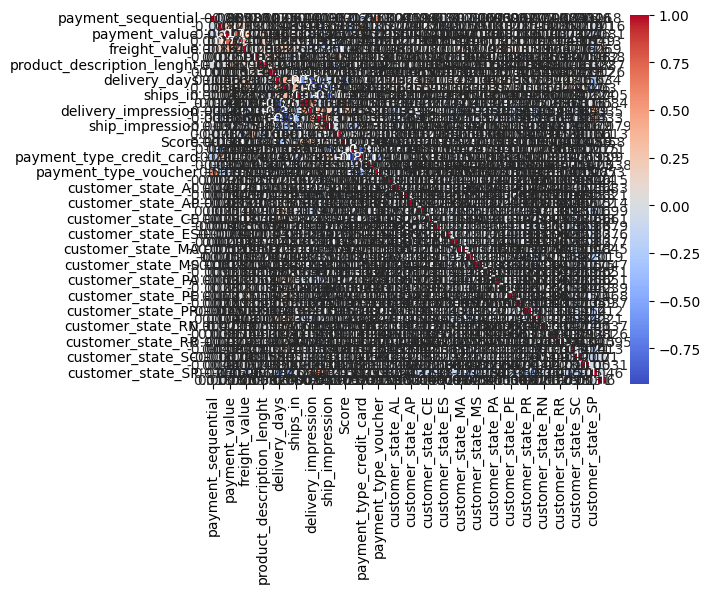

In [9]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

In [10]:
score_correlations = correlation_matrix['Score']
top_features = score_correlations.abs().nlargest(10).index.tolist()  # Include Score itself


<Axes: >

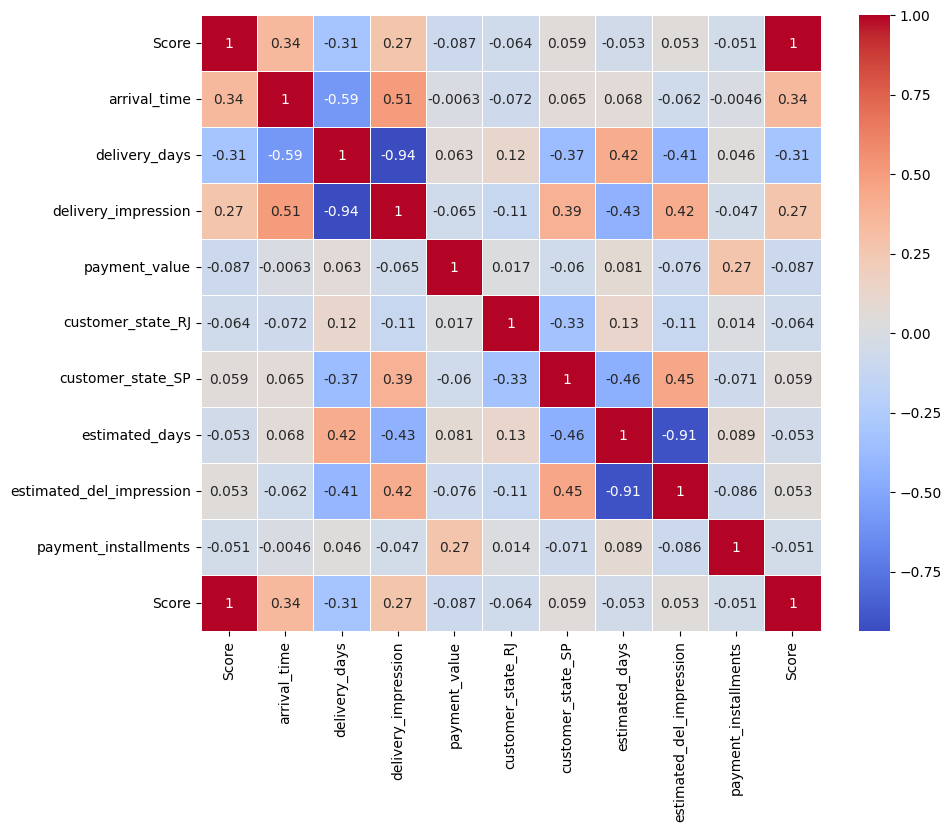

In [11]:
# Create a new correlation matrix for the top features
top_correlation_matrix = correlation_matrix.loc[top_features + ['Score'], top_features + ['Score']]

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap for the selected features
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

In [12]:
X = data.drop('Score',axis=1)
Y = data.Score.values

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.33,stratify=Y,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(68542, 47) (33760, 47) (68542,) (33760,)


In [13]:
from sklearn.preprocessing import StandardScaler  # or StandardScaler
scaler = StandardScaler()  # You can use StandardScaler() if preferred

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (note we don't fit on the test data!)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames if needed
##X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
##X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


## Naive Bayes

In [14]:
# Step 4: Initialize and fit the Naive Bayes model
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test_scaled)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.79
Confusion Matrix:
[[ 2124  3273]
 [ 3959 24404]]


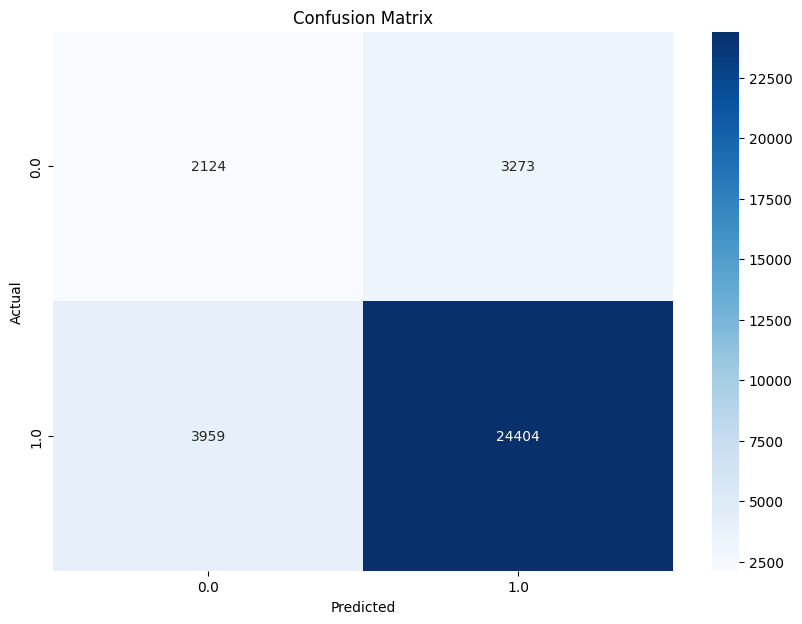

In [15]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

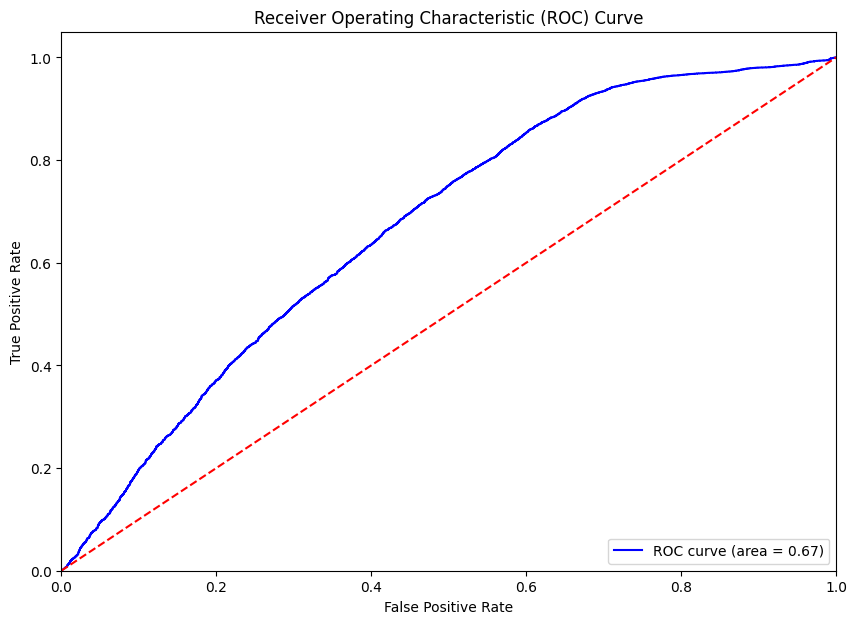

In [16]:
from sklearn.metrics import roc_curve, auc

# Step 2: Compute the predicted probabilities for the positive class
y_scores = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Step 3: Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)  # Use the appropriate label for the positive class
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming y_test and y_pred are already defined from your previous Naive Bayes model

# Step 1: Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
recall = recall_score(y_test, y_pred, average='weighted')        # Use 'macro' or 'micro' if needed
f1 = f1_score(y_test, y_pred, average='weighted')


# Step 2: Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall','F1 Score'],
    'Score': [accuracy, precision, recall,f1]
})
metrics_df

,Metric,Score
0,Accuracy,0.785782
1,Precision,0.796604
2,Recall,0.785782
3,F1 Score,0.790871


## Logistic Regression

In [18]:
# Step 4: Train the Logistic Regression model
model2 = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test_scaled)

# Step 6: Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro', 'micro' if needed
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Step 7: Create a DataFrame to store the metrics
metrics_df2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})
metrics_df2

,Metric,Score
0,Accuracy,0.785782
1,Precision,0.796604
2,Recall,0.785782
3,F1 Score,0.790871


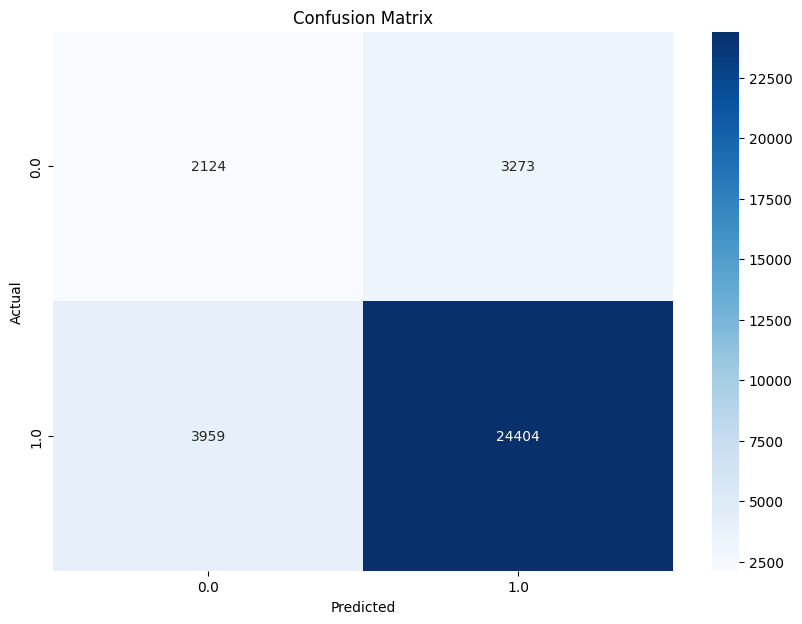

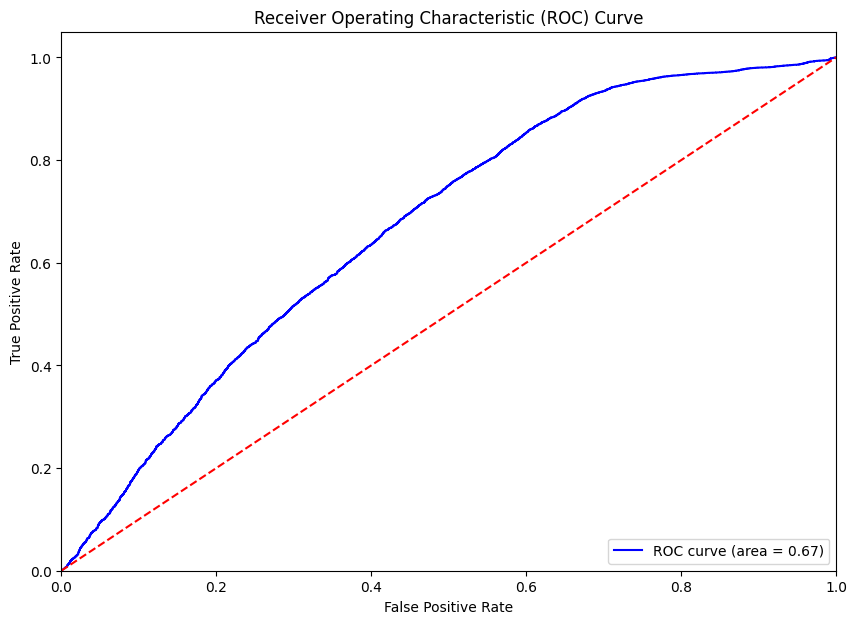

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_scores = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Random Forest

In [20]:
# #rf_model = RandomForestClassifier(random_state=42)

# # Step 5: Set up the GridSearchCV to tune hyperparameters
# #param_grid = {
#  #   'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [10, 20, 30],        # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split
#     'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node
#     'bootstrap': [True, False]        # Whether bootstrap samples are used
# }

# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# # Step 6: Fit the GridSearchCV
# grid_search.fit(X_train_scaled, y_train)

# # Step 7: Get the best estimator from GridSearchCV
# best_rf_model = grid_search.best_estimator_

# # Step 8: Make predictions
# y_pred = best_rf_model.predict(X_test_scaled)

# # Step 9: Calculate the evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='weighted')  # Change 'weighted' to 'macro' or 'micro' based on your need
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')

# # Step 10: Create a DataFrame to store the metrics
# metrics_df3 = pd.DataFrame({
#     'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
#     'Score': [accuracy, precision, recall, f1]
# })
# metrics_df3

In [21]:
rf_model = RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=200,random_state=42).fit(X_train_scaled, y_train)

# Step 8: Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Step 9: Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Change 'weighted' to 'macro' or 'micro' based on your need
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Step 10: Create a DataFrame to store the metrics
metrics_df3 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})
metrics_df3

,Metric,Score
0,Accuracy,0.904621
1,Precision,0.902091
2,Recall,0.904621
3,F1 Score,0.892393


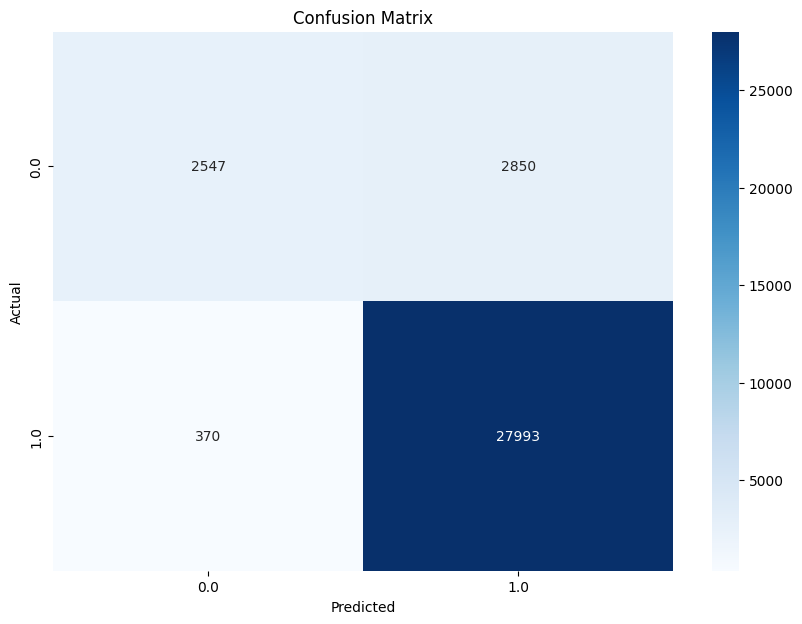

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




In [23]:
metrics_df3.rename(columns={'Score': 'Random Forest Score'}, inplace=True)


In [24]:
metrics_df2.rename(columns={'Score': 'Logistic Regression Score'}, inplace=True)


In [25]:
metrics_df.rename(columns={'Score': 'Naive Bayes Score'}, inplace=True)


In [26]:
metrics_df2

,Metric,Logistic Regression Score
0,Accuracy,0.785782
1,Precision,0.796604
2,Recall,0.785782
3,F1 Score,0.790871


In [27]:
combined_metrics_df = metrics_df.merge(metrics_df2, on='Metric').merge(metrics_df3, on='Metric')
combined_metrics_df

,Metric,Naive Bayes Score,Logistic Regression Score,Random Forest Score
0,Accuracy,0.785782,0.785782,0.904621
1,Precision,0.796604,0.796604,0.902091
2,Recall,0.785782,0.785782,0.904621
3,F1 Score,0.790871,0.790871,0.892393


### So Random Forest Will be our model

### Check Overfitting

In [28]:
# Step 1: Make predictions on the training set
y_train_pred = rf_model.predict(X_train_scaled)

# Step 2: Calculate the evaluation metrics for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Step 3: Create a DataFrame for training metrics
metrics_train = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Training Score': [train_accuracy, train_precision, train_recall, train_f1]
})

# Step 4: Add the test set metrics to the DataFrame
metrics_test = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Test Score': [accuracy, precision, recall, f1]
})

# Combine the metrics for easy comparison
combined_metrics = metrics_train.merge(metrics_test, on='Metric')

# Display the combined metrics
combined_metrics

,Metric,Training Score,Test Score
0,Accuracy,0.995579,0.904621
1,Precision,0.995596,0.902091
2,Recall,0.995579,0.904621
3,F1 Score,0.995556,0.892393


In [29]:
import pickle

# Step 1: Define the file path where you want to save the model
filename = 'rf_model.pkl'

# Step 2: Save the trained model using pickle
with open(filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved as {filename}")


Model saved as rf_model.pkl
